In [1]:
import pandas as pd
import numpy as np
import geopandas
#import difflib
import multiprocess
import diff_match_patch as dmp_module

DIR_DATA = 'Data/'

In [2]:
def GMLtoGDF(filename):
    gdf = geopandas.read_file(filename)
    gdf.rename_geometry('Geometry', inplace=True) # Default geometry column name is 'geometry'; changed for consistent capitalization of columns
    gdf.set_geometry('Geometry') # Renaming is insufficient; this sets special variable gdf.geometry = gdf['Geometry']
    gdf = gdf.set_crs(epsg=3347) # Needed only for FSA file, the others are 3347 and parsed correctly by geopandas, and the pdf in the zip file has the same projection parameters (FSA vs. DA, ADA, CT)
    gdf['Area'] = gdf['Geometry'].to_crs(epsg=6931).area # Equal-area projection
    gdf['Centroid'] = gdf['Geometry'].centroid
    gdf['Geometry'] = gdf['Geometry'].to_crs(epsg=4326) # Latitude/Longitude representation
    gdf['Centroid'] = gdf['Centroid'].to_crs(epsg=4326) # Only the set geometry is converted with gdf.to_crs(); all other geometry-containing columns must be converted explicitly; here we convert all columns explicitly
    gdf = gdf.set_crs(epsg=4326) # The series and geodataframe can have separate crs; this was found necessary for the geopandas.union function to operate easily
    gdf['Centroid Latitude'] = gdf['Centroid'].geometry.y
    gdf['Centroid Longitude'] = gdf['Centroid'].geometry.x
    gdf.drop(columns = 'Centroid', inplace=True) # Because WKT Point cannot be serialized to JSON, we drop the Centroid column and keep only its float components
    return gdf

In [3]:
%%time
gdf_CA_FSA = GMLtoGDF(DIR_DATA+'lfsa000b16g_e.gml')

C:\Users\Arkadiatri\anaconda3\envs\Coursera\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Wall time: 45.6 s


In [4]:
%%time
gdf_CA_DA = GMLtoGDF(DIR_DATA+'lda_000b16g_e.gml')

Wall time: 1min 51s


In [5]:
%%time
gdf1 = gdf_CA_FSA
gdf1b = gdf1.copy(deep=True)
gdf1b['Geometry'] = gdf1b['Geometry'].buffer(0)
gdf2 = gdf_CA_DA
gdf2b = gdf2.copy(deep=True)
gdf2b['Geometry'] = gdf2b['Geometry'].buffer(0)

Wall time: 1min 43s


In [24]:
import multiprocess
import testmp
import time
import ipypb # Lightweight progress bar, source copied from GitHub

if __name__ == '__main__':
    completed = 0
    N = gdf1.shape[0]
    results = [None]*N
    NUM_PROCESSES = 10
    start_time = time.time()
    with multiprocess.Pool(NUM_PROCESSES) as pool:
        print(f'Generating pool, P={NUM_PROCESSES}, N={N}')
        ret = [pool.apply_async(testmp.dmpDiff,(gdf1['Geometry'].iloc[ind], gdf1b['Geometry'].iloc[ind], ind)) for ind in range(N)]
        print('Processing pool')
        for i in ipypb.track(range(N)): # Alternative: initialize pb and call next(pb) in loop, instead of having a while loop to process all updates since last loop
            while True:
                indb_finished = [r.ready() for r in ret]
                indb_empty = [r==None for r in results]
                indb_update = [f and e for f, e in zip(indb_finished, indb_empty)]
                if any(indb_update):
                    ind_update = indb_update.index(True)
                    results[ind_update] = ret[ind_update].get(999999)
                    completed += 1
                    break
            
    wall_time = time.time()-start_time
    processor_time = sum([sum(r[2]) for r in results])
    print(f'Pool processing concluded, process count {sum([r!=None for r in results])}/{N}, wall time {time.strftime("%H:%M:%S", time.gmtime(wall_time))}, processor time {time.strftime("%H:%M:%S", time.gmtime(processor_time))}, speedup {processor_time/wall_time:.3}x')

Generating pool, P=10, N=1620
Processing pool


 [████████████████████████████████████████████████████████████] 1620/1620 [01:04<00:00, 0.04s/it]

Pool processing concluded, process count 1620/1620, wall time 00:01:04, processor time 00:04:32, speedup 4.19x


In [29]:
results[3][1]

3

Note that dmp reduction can occur

There are no newlines in wkt representation, so we can replace commas with newlines, process, and it will look like the difflib results.  This is necessary because the diff_match_patch module, in line mode, looks for newlines explicitly (does not take delimiters as a parameter)... this might be worth modifiying.

In [247]:
import multiprocess
import testmp
import time
import ipypb # Lightweight progress bar, source copied from GitHub

if __name__ == '__main__':
    completed = 0
    N = gdf1.shape[0]
    results = [None]*N
    NUM_PROCESSES = 10
    start_time = time.time()
    with multiprocess.Pool(NUM_PROCESSES) as pool:
        print(f'Generating pool, P={NUM_PROCESSES}, N={N}')
        ret = [pool.apply_async(testmp.dmpDiffLine,(gdf1['Geometry'].iloc[ind], gdf1b['Geometry'].iloc[ind], ind)) for ind in range(N)]
        print('Processing pool')
        for i in ipypb.track(range(N)): # Alternative: initialize pb and call next(pb) in loop, instead of having a while loop to process all updates since last loop
            while True:
                indb_finished = [r.ready() for r in ret]
                indb_empty = [r==None for r in results]
                indb_update = [f and e for f, e in zip(indb_finished, indb_empty)]
                if any(indb_update):
                    ind_update = indb_update.index(True)
                    results[ind_update] = ret[ind_update].get(999999)
                    completed += 1
                    break
            
    wall_time = time.time()-start_time
    processor_time = sum([sum(r[2]) for r in results])
    print(f'Pool processing concluded, process count {sum([r!=None for r in results])}/{N}, wall time {time.strftime("%H:%M:%S", time.gmtime(wall_time))}, processor time {time.strftime("%H:%M:%S", time.gmtime(processor_time))}, speedup {processor_time/wall_time:.3}x')

Generating pool, P=10, N=1620
Processing pool


 [████████████████████████████████████████████████████████████] 1620/1620 [01:19<00:01, 0.05s/it]

Pool processing concluded, process count 1620/1620, wall time 00:01:20, processor time 00:05:18, speedup 3.96x


In [248]:
results[3][0][1]

(1,
 ' ((-60.5429564403791929 45.9537180084970345, -60.5448906213733764 45.9537505817917449, -60.5455058031878508 45.9544298523307475, -60.5469479251703433 45.9547938752033289, -60.5467664055057213 45.9556900440364444, -60.5446255904107105 45.9571201436021184, -60.5438181102048674 45.9569947776894523, -60.5433727001601696 45.9559771270246173, -60.5424127780226229 45.9555064350946196, -60.5413124922581503 45.9547087018396851, -60.5410023790832952 45.9541349771329379, -60.5429564403791929 45.9537180084970345)),')

    diff1_i1 : All lines, was previously diff1_instance
    diff1_i2 : Only diff lines

In [249]:
%%time
diff1_i1 = [[[('- ' if i<0 else '+ ' if i>0 else '  ')+ss for ss in s.split(',') if ss!=''] for i, s in r[0]] for r in results]

Wall time: 2.52 s


In [213]:
diff1_i1[3]

[['  MULTIPOLYGON (((-60.2912939670218790 46.0744175797466937',
  '   -60.2951144442927358 46.0735109378293757',
  '   -60.2977626525622483 46.0726066050999705',
  '   -60.2997994543740248 46.0717784818895879',
  '   -60.3011528868724369 46.0710671787275245',
  '   -60.3027516831617731 46.0703192781243089',
  '   -60.3057318885868412 46.0697247486147887',
  '   -60.3083349051831448 46.0688493413092885',
  '   -60.3092730880931498 46.0682972850007459',
  '   -60.3098644877711720 46.0677370723058601',
  '   -60.3104574788803447 46.0671466287953422',
  '   -60.3112353608866840 46.0663188132966468',
  '   -60.3119552846996285 46.0657918190567912',
  '   -60.3126767917139119 46.0654409218899161',
  '   -60.3137331007221036 46.0649271137819056',
  '   -60.3152941629398001 46.0640571943458497',
  '   -60.3156413966177780 46.0638311830096185',
  '   -60.3158511118527230 46.0636946797010083',
  '   -60.3167313841422157 46.0631218883391682',
  '   -60.3167324045084996 46.0631210024945617',
  '  

In [250]:
%%time
diff1_i2 = [[[('- ' if i<0 else '+ ' if i>0 else '  ')+ss for ss in s.split(',') if ss!=''] for i, s in r[0] if i!=0] for r in results]

Wall time: 1.91 s


In [230]:
diff1_i2[3]

[['+  ((-60.5429564403791929 45.9537180084970345',
  '+  -60.5448906213733764 45.9537505817917449',
  '+  -60.5455058031878508 45.9544298523307475',
  '+  -60.5469479251703433 45.9547938752033289',
  '+  -60.5467664055057213 45.9556900440364444',
  '+  -60.5446255904107105 45.9571201436021184',
  '+  -60.5438181102048674 45.9569947776894523',
  '+  -60.5433727001601696 45.9559771270246173',
  '+  -60.5424127780226229 45.9555064350946196',
  '+  -60.5413124922581503 45.9547087018396851',
  '+  -60.5410023790832952 45.9541349771329379',
  '+  -60.5429564403791929 45.9537180084970345))'],
 ['+  ((-60.5513075911979186 45.9495680163224023',
  '+  -60.5522645078240984 45.9498135394415996',
  '+  -60.5517530844695102 45.9505856443399807',
  '+  -60.5509318662346274 45.9513600866115439',
  '+  -60.5491106216154122 45.9525721352205849',
  '+  -60.5476663419012624 45.9525501340616245',
  '+  -60.5475303145262629 45.9515391365480141',
  '+  -60.5493434325647115 45.9502189447510503',
  '+  -60.551

In [251]:
%%time
diff1_1 = [[] for d in diff1_i1]
_ = [[l.extend(dd) for dd in d if dd!=''] for d, l in zip(diff1_i1, diff1_1)]

Wall time: 225 ms


In [232]:
diff1_1[3]

['  MULTIPOLYGON (((-60.2912939670218790 46.0744175797466937',
 '   -60.2951144442927358 46.0735109378293757',
 '   -60.2977626525622483 46.0726066050999705',
 '   -60.2997994543740248 46.0717784818895879',
 '   -60.3011528868724369 46.0710671787275245',
 '   -60.3027516831617731 46.0703192781243089',
 '   -60.3057318885868412 46.0697247486147887',
 '   -60.3083349051831448 46.0688493413092885',
 '   -60.3092730880931498 46.0682972850007459',
 '   -60.3098644877711720 46.0677370723058601',
 '   -60.3104574788803447 46.0671466287953422',
 '   -60.3112353608866840 46.0663188132966468',
 '   -60.3119552846996285 46.0657918190567912',
 '   -60.3126767917139119 46.0654409218899161',
 '   -60.3137331007221036 46.0649271137819056',
 '   -60.3152941629398001 46.0640571943458497',
 '   -60.3156413966177780 46.0638311830096185',
 '   -60.3158511118527230 46.0636946797010083',
 '   -60.3167313841422157 46.0631218883391682',
 '   -60.3167324045084996 46.0631210024945617',
 '   -60.3167727602781341

In [252]:
%%time
diff1_2 = [[] for d in diff1_i2]
_ = [[l.extend(dd) for dd in d if dd!=''] for d, l in zip(diff1_i2, diff1_2)]

Wall time: 403 ms


In [234]:
diff1_2[3]

['+  ((-60.5429564403791929 45.9537180084970345',
 '+  -60.5448906213733764 45.9537505817917449',
 '+  -60.5455058031878508 45.9544298523307475',
 '+  -60.5469479251703433 45.9547938752033289',
 '+  -60.5467664055057213 45.9556900440364444',
 '+  -60.5446255904107105 45.9571201436021184',
 '+  -60.5438181102048674 45.9569947776894523',
 '+  -60.5433727001601696 45.9559771270246173',
 '+  -60.5424127780226229 45.9555064350946196',
 '+  -60.5413124922581503 45.9547087018396851',
 '+  -60.5410023790832952 45.9541349771329379',
 '+  -60.5429564403791929 45.9537180084970345))',
 '+  ((-60.5513075911979186 45.9495680163224023',
 '+  -60.5522645078240984 45.9498135394415996',
 '+  -60.5517530844695102 45.9505856443399807',
 '+  -60.5509318662346274 45.9513600866115439',
 '+  -60.5491106216154122 45.9525721352205849',
 '+  -60.5476663419012624 45.9525501340616245',
 '+  -60.5475303145262629 45.9515391365480141',
 '+  -60.5493434325647115 45.9502189447510503',
 '+  -60.5513075911979186 45.94956

Now check the lengths

In [253]:
%%time
len_diff1_1 = [sum(len(dd) for dd in d) for d in diff1_1]
len_diff1_2 = [sum(len(dd) for dd in d) for d in diff1_2]
all([a>=b for a, b in zip(len_diff1_1,len_diff1_2)])

Wall time: 2.1 s


True

In [254]:
[*zip(len_diff1_1,len_diff1_2)][809]

(98468034, 98468034)

In [255]:
len(diff1_i1[809][0]),len(diff1_i1[809][1])

(1138219, 1138221)

In [256]:
np.argmax(len_diff1_1), np.argmax(len_diff1_2)

(809, 809)

In [257]:
a = np.sort(len_diff1_2)

In [262]:
a[-4]

8735374

In [45]:
%%time
diff1_instance_divided = [[[(i, ss) for ss in s.split(',')] for i, s in r[0]] for r in results]

Wall time: 3.52 s


In [ ]:
diff1_instance_divided[3]

In [ ]:
[[for i, s in r[0]] for r in results]

In [211]:
diff1_instance[3]

['+  ((-60.5429564403791929 45.9537180084970345',
 '+  -60.5448906213733764 45.9537505817917449',
 '+  -60.5455058031878508 45.9544298523307475',
 '+  -60.5469479251703433 45.9547938752033289',
 '+  -60.5467664055057213 45.9556900440364444',
 '+  -60.5446255904107105 45.9571201436021184',
 '+  -60.5438181102048674 45.9569947776894523',
 '+  -60.5433727001601696 45.9559771270246173',
 '+  -60.5424127780226229 45.9555064350946196',
 '+  -60.5413124922581503 45.9547087018396851',
 '+  -60.5410023790832952 45.9541349771329379',
 '+  -60.5429564403791929 45.9537180084970345))',
 '+  ((-60.5513075911979186 45.9495680163224023',
 '+  -60.5522645078240984 45.9498135394415996',
 '+  -60.5517530844695102 45.9505856443399807',
 '+  -60.5509318662346274 45.9513600866115439',
 '+  -60.5491106216154122 45.9525721352205849',
 '+  -60.5476663419012624 45.9525501340616245',
 '+  -60.5475303145262629 45.9515391365480141',
 '+  -60.5493434325647115 45.9502189447510503',
 '+  -60.5513075911979186 45.94956

In [200]:
diff1_i1_donly[3]

[['+  ((-60.5429564403791929 45.9537180084970345',
  '+  -60.5448906213733764 45.9537505817917449',
  '+  -60.5455058031878508 45.9544298523307475',
  '+  -60.5469479251703433 45.9547938752033289',
  '+  -60.5467664055057213 45.9556900440364444',
  '+  -60.5446255904107105 45.9571201436021184',
  '+  -60.5438181102048674 45.9569947776894523',
  '+  -60.5433727001601696 45.9559771270246173',
  '+  -60.5424127780226229 45.9555064350946196',
  '+  -60.5413124922581503 45.9547087018396851',
  '+  -60.5410023790832952 45.9541349771329379',
  '+  -60.5429564403791929 45.9537180084970345))'],
 ['+  ((-60.5513075911979186 45.9495680163224023',
  '+  -60.5522645078240984 45.9498135394415996',
  '+  -60.5517530844695102 45.9505856443399807',
  '+  -60.5509318662346274 45.9513600866115439',
  '+  -60.5491106216154122 45.9525721352205849',
  '+  -60.5476663419012624 45.9525501340616245',
  '+  -60.5475303145262629 45.9515391365480141',
  '+  -60.5493434325647115 45.9502189447510503',
  '+  -60.551

In [201]:
len_diff1_instance = [sum(len(dd) for dd in d) for d in diff1_instance]

In [207]:
len_diff1_instance[809]

98468034

In [202]:
len_diff1_i1= [sum(len(dd) for dd in d) for d in diff1_i1]

In [209]:
len_diff1_i1[809]

2276440

In [203]:
len_diff1_i1_donly = [sum(len(dd) for dd in d) for d in diff1_i1_donly]

In [210]:
len_diff1_i1_donly[809]

2276440

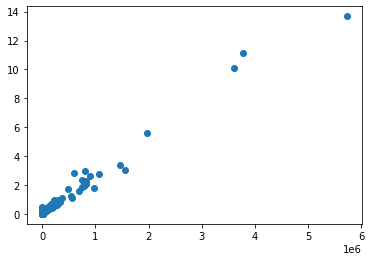

In [171]:
plt.scatter(y[:len(t)],np.sqrt(t))

Ahah, the time is quadratic in the output length...

In [196]:
diff1_i1[3]

[['+  ((-60.5429564403791929 45.9537180084970345',
  '+  -60.5448906213733764 45.9537505817917449',
  '+  -60.5455058031878508 45.9544298523307475',
  '+  -60.5469479251703433 45.9547938752033289',
  '+  -60.5467664055057213 45.9556900440364444',
  '+  -60.5446255904107105 45.9571201436021184',
  '+  -60.5438181102048674 45.9569947776894523',
  '+  -60.5433727001601696 45.9559771270246173',
  '+  -60.5424127780226229 45.9555064350946196',
  '+  -60.5413124922581503 45.9547087018396851',
  '+  -60.5410023790832952 45.9541349771329379',
  '+  -60.5429564403791929 45.9537180084970345))'],
 ['+  ((-60.5513075911979186 45.9495680163224023',
  '+  -60.5522645078240984 45.9498135394415996',
  '+  -60.5517530844695102 45.9505856443399807',
  '+  -60.5509318662346274 45.9513600866115439',
  '+  -60.5491106216154122 45.9525721352205849',
  '+  -60.5476663419012624 45.9525501340616245',
  '+  -60.5475303145262629 45.9515391365480141',
  '+  -60.5493434325647115 45.9502189447510503',
  '+  -60.551

In [193]:
y = diff1_instance[3]
y

['+  ((-60.5429564403791929 45.9537180084970345',
 '+  -60.5448906213733764 45.9537505817917449',
 '+  -60.5455058031878508 45.9544298523307475',
 '+  -60.5469479251703433 45.9547938752033289',
 '+  -60.5467664055057213 45.9556900440364444',
 '+  -60.5446255904107105 45.9571201436021184',
 '+  -60.5438181102048674 45.9569947776894523',
 '+  -60.5433727001601696 45.9559771270246173',
 '+  -60.5424127780226229 45.9555064350946196',
 '+  -60.5413124922581503 45.9547087018396851',
 '+  -60.5410023790832952 45.9541349771329379',
 '+  -60.5429564403791929 45.9537180084970345))',
 '+  ((-60.5513075911979186 45.9495680163224023',
 '+  -60.5522645078240984 45.9498135394415996',
 '+  -60.5517530844695102 45.9505856443399807',
 '+  -60.5509318662346274 45.9513600866115439',
 '+  -60.5491106216154122 45.9525721352205849',
 '+  -60.5476663419012624 45.9525501340616245',
 '+  -60.5475303145262629 45.9515391365480141',
 '+  -60.5493434325647115 45.9502189447510503',
 '+  -60.5513075911979186 45.94956

In [119]:
print(results[3])

([(0, 'MULTIPOLYGON (((-60.2912939670218790 46.0744175797466937, -60.2951144442927358 46.0735109378293757, -60.2977626525622483 46.0726066050999705, -60.2997994543740248 46.0717784818895879, -60.3011528868724369 46.0710671787275245, -60.3027516831617731 46.0703192781243089, -60.3057318885868412 46.0697247486147887, -60.3083349051831448 46.0688493413092885, -60.3092730880931498 46.0682972850007459, -60.3098644877711720 46.0677370723058601, -60.3104574788803447 46.0671466287953422, -60.3112353608866840 46.0663188132966468, -60.3119552846996285 46.0657918190567912, -60.3126767917139119 46.0654409218899161, -60.3137331007221036 46.0649271137819056, -60.3152941629398001 46.0640571943458497, -60.3156413966177780 46.0638311830096185, -60.3158511118527230 46.0636946797010083, -60.3167313841422157 46.0631218883391682, -60.3167324045084996 46.0631210024945617, -60.3167727602781341 46.0630947495163525, -60.3173053276437159 46.0628780454762676, -60.3188090655660787 46.0622661754702349, -60.3197382

In [66]:
diff1_len = [sum(1 for _ in d) for d in diff1_i2]

In [68]:
diff1_instance = diff1_i2

In [69]:
# Find the number of line alterations for each geometry pair
diff1_changecount = [sum(1 for e in d if e[0]!=' ') for d in diff1_instance]

In [71]:
diff1_changenumber = sum(np.array(diff1_changecount)>0)
buffind_diff1 = np.nonzero(diff1_changecount)[0]
print(f'There are {diff1_changenumber} FSA geometries with alterations upon buffering')
print('Indices of altered FSA geometries:')
print(buffind_diff1)

There are 312 FSA geometries with alterations upon buffering
Indices of altered FSA geometries:
[   3   11   14   20   21   22   23   24   25   26   27   28   29   30
   31   35   40   46   48   49   50   51   52   54   56   57   59   60
   61   62   63   64   65   67   70   73   74   75   86   89   90  100
  101  103  105  107  115  117  124  126  127  138  144  153  157  158
  160  161  162  171  177  178  202  204  205  226  229  230  231  236
  237  238  240  241  244  248  250  251  252  253  266  282  284  293
  315  316  345  349  353  361  363  367  393  405  409  415  443  451
  458  467  475  477  478  480  481  482  483  484  485  487  488  489
  491  492  506  507  508  516  542  545  548  549  552  556  557  565
  568  570  571  576  577  580  581  586  591  592  594  597  599  601
  602  638  640  641  643  645  648  653  658  674  677  689  695  696
  698  699  705  711  714  716  717  719  720  731  732  737  750  756
  761  769  770  783  792  796  800  802  808  809  

In [72]:
all(np.where(match1==False)[0] == np.where(np.array(diff1_changecount)>0)[0])

NameError: name 'match1' is not defined

In [73]:
minind = 0 # Index to display, sorted by ascending number of diff lines
ind_changed = np.where(np.array(diff1_changecount)>0)[0]
ind_changed_minlen = ind_changed[np.argsort(np.array(diff1_len)[ind_changed])[minind]]
print(f"The {1+minind}{'st' if 1+minind==1 else 'nd' if 1+minind==2 else 'rd' if 1+minind==3 else 'th'} shortest geometry that changes with buffering is at index {ind_changed_minlen} with length of {diff1_len[ind_changed_minlen]} coordinates (including modification listings)\n")
display(diff1_instance[ind_changed_minlen])

The 1st shortest geometry that changes with buffering is at index 1304 with length of 150 coordinates (including modification listings)



['- MULTIPOLYGON (((-80.9961370101102602 43.3647863077078100',
 '- ',
 '+ MULTIPOLYGON (((-80.9465541104391235 43.3708068955520076',
 '+  -80.9481151078120433 43.3708356922337472',
 '+  -80.9481702033535555 43.3717801952372568',
 '+  -80.9481446051861013 43.3728517109411271',
 '+  -80.9481107842565279 43.3729582073078674',
 '+  -80.9481305007772818 43.3749406912792210',
 '+  -80.9481412670495217 43.3756409299859129',
 '+  -80.9481769613963849 43.3759174577566853',
 '+  -80.9481817328073987 43.3759850149050550',
 '+  -80.9481085053282925 43.3759831089868300',
 '+  -80.9474877416748768 43.3759669264657433',
 '+  -80.9467963413254097 43.3760836789074915',
 '+  -80.9456574385654477 43.3760316727947455',
 '+  -80.9454189559373134 43.3760207964764319',
 '+  -80.9454173346963728 43.3760207186801665',
 '+  -80.9454014954826562 43.3760199875219286',
 '+  -80.9451797624440985 43.3760236225991207',
 '+  -80.9431273440702768 43.3760572928782366',
 '+  -80.9428868007644837 43.3760612398056793',
 '+

In [74]:
def condenseDiff(diff):
    '''Extracts changed lines from diff and cancels equivalent additions and subtractions.
    
    Parameters
    ----------
    diff: a list of strings, the result of a line difference (difflib.ndiff())
    
    Returns
    -------
    list of strings, the lines of diff comprising changes that do not appear as both additions and subtractions
    '''
    addlist = set(d[2:] for d in diff if d[0]=='+')
    sublist = set(d[2:] for d in diff if d[0]=='-')
    addlist_short = addlist.difference(sublist)
    sublist_short = sublist.difference(addlist)
    addlist_short = ['+ '+a for a in addlist_short]
    sublist_short = ['- '+s for s in sublist_short]
    return [*addlist_short, *sublist_short]

In [152]:
condenseDiff(diff1_instance[3])

['+  -60.5513075911979186 45.9495680163224023))',
 '+  -60.5745313899581390 45.9490194597258821)))',
 '-  -60.5745313899581390 45.9490194597258821))',
 '-  -60.5513075911979186 45.9495680163224023)))']

In [102]:
def condenseDiffPoints(diff, keep_comments=False, strip_test=False, strip_output=False, use_sets=False):
    '''Extracts changed lines from diff and cancels equivalent additions and subtractions.
    
    Parameters
    ----------
    diff: list of str, the result of a line difference (difflib.ndiff()) on a WKT geometry that was split by comma delimiters
    keep_comments: bool, if True, comments prefixed by '?' and their associated line are kept even if the associated line's point could be paired and cancelled
    strip_test: bool, if True, 
    strip_output: bool, if True, returns the bare points prefixed with addition and subtraction instead of the original diff line
    use_sets: bool, if True, perform cancelling using sets instead of lists (may not preserve point repetition)
    
    Returns
    -------
    list of strings, the lines of diff comprising changes that do not appear as both additions and subtractions
    
    Notes
    -----
    1) Create stripped lists for cancel testing
    '''
    diff = np.array(diff.copy())
    addind = list(np.where([d[0]=='+' for d in diff])[0])
    subind = list(np.where([d[0]=='-' for d in diff])[0])
    altind = list(np.where([d[0]=='?' for d in diff])[0]) # if difflib.ndiff() functions properly, '?' only follows '+' or '-'
    
    if keep_comments==False:
        altind = []
        addind_alt = []
        subind_alt = []
        addind_lon = addind
        subind_lon = subind
    else:
        addind_alt = [i for i in addind if (i+1) in altind]
        subind_alt = [i for i in subind if (i+1) in altind]
        addind_lon = [i for i in addind if not (i in addind_alt)]
        subind_lon = [i for i in subind if not (i in subind_alt)]

    # Get only the points for comparison
    difflist = np.array([d[2:] for d in diff])
    if strip_test:
        difflist = np.array([d[(d.rfind("(")+1):(len(d) if d.find(")")==-1 else d.find(")"))] for d in difflist])
    addlist = difflist[addind]
    sublist = difflist[subind]

    if use_sets:
        addlist = set(addlist)
        sublist = set(sublist)
        addlist_short = addlist.difference(sublist)
        sublist_short = sublist.difference(addlist)
        addind_short = [np.where(difflist==r)[0][0] for r in addlist_short]
        subind_short = [np.where(difflist==r)[0][0] for r in sublist_short]
        strip_output = True

    else:
        addlist_short = []
        addind_short = []
        sublist_short = sublist.copy()
        sublist_short = list(np.array(sublist_short)[[list(subind).index(i) for i in subind_lon]])
        subind_short = subind_lon.copy()

        for ind, val in zip(addind, addlist):
            if ind in addind_lon:
                if val in sublist_short:
                    sind = sublist_short.index(val)
                    sublist_short.remove(val)
                    subind_short.remove(subind_short[sind])
                else:
                    addlist_short.append(val)
                    addind_short.append(ind)
    
    ret_ind = addind_alt + subind_alt + altind + addind_short + subind_short
    ret_ind.sort()
    
    if strip_output:
        retlist  = list(difflist[ret_ind])
        retlist = [('+ ' if (d in addind_alt + addind_short) else '- ' if (d in subind_alt+subind_short) else '? ') + r.strip() for d, r in zip(ret_ind,retlist)]
    else:
        retlist = list(diff[ret_ind])
    return retlist

In [155]:
condenseDiffPoints(diff1_instance[3], keep_comments=True, strip_test=False)

['+  -60.5513075911979186 45.9495680163224023))',
 '-  -60.5745313899581390 45.9490194597258821))',
 '-  -60.5513075911979186 45.9495680163224023)))',
 '+  -60.5745313899581390 45.9490194597258821)))']

In [176]:
diff1_instance[3]

['+  ((-60.5429564403791929 45.9537180084970345',
 '+  -60.5448906213733764 45.9537505817917449',
 '+  -60.5455058031878508 45.9544298523307475',
 '+  -60.5469479251703433 45.9547938752033289',
 '+  -60.5467664055057213 45.9556900440364444',
 '+  -60.5446255904107105 45.9571201436021184',
 '+  -60.5438181102048674 45.9569947776894523',
 '+  -60.5433727001601696 45.9559771270246173',
 '+  -60.5424127780226229 45.9555064350946196',
 '+  -60.5413124922581503 45.9547087018396851',
 '+  -60.5410023790832952 45.9541349771329379',
 '+  -60.5429564403791929 45.9537180084970345))',
 '+  ((-60.5513075911979186 45.9495680163224023',
 '+  -60.5522645078240984 45.9498135394415996',
 '+  -60.5517530844695102 45.9505856443399807',
 '+  -60.5509318662346274 45.9513600866115439',
 '+  -60.5491106216154122 45.9525721352205849',
 '+  -60.5476663419012624 45.9525501340616245',
 '+  -60.5475303145262629 45.9515391365480141',
 '+  -60.5493434325647115 45.9502189447510503',
 '+  -60.5513075911979186 45.94956

In [89]:
%%time
import time
x = [] # Condensed diff1_instance
t = [] # computation time
for i in range(len(diff1_instance)):
    start_time = time.time()
    x.append(condenseDiffPoints(diff1_instance[i], keep_comments=False, strip_test=True))
    end_time = time.time()
    t.append(end_time-start_time)
    print(f'{i}, {t[-1]:.6}')

0, 0.00199437
1, 0.00199533
2, 0.00398922
3, 0.0159569
4, 0.0199478
5, 0.0159562
6, 0.00299239
7, 0.0050199
8, 0.00695086
9, 0.00302315
10, 0.00299382
11, 0.00697947
12, 0.00199699
13, 0.00201178
14, 0.00698972
15, 0.014962
16, 0.00299001
17, 0.00694823
18, 0.000997066
19, 0.0149591
20, 3.81972
21, 4.25241
22, 0.245803
23, 0.498132
24, 187.205
25, 5.16915
26, 9.16552
27, 11.2502
28, 3.34308
29, 0.699086
30, 1.15358
31, 5.35714
32, 0.0282671
33, 0.0096693
34, 0.0
35, 0.110215
36, 0.0100489
37, 0.0
38, 0.0
39, 0.0
40, 0.0202436
41, 0.0
42, 0.0198324
43, 0.029978
44, 0.00992131
45, 0.0
46, 0.580161
47, 0.0400097
48, 0.0198374
49, 7.00578
50, 0.563102
51, 101.923
52, 0.0987368
53, 0.00997233
54, 0.0498669
55, 0.0708106
56, 0.307178
57, 0.0684602
58, 0.0401239
59, 0.419841
60, 0.470054
61, 7.49012
62, 0.0299177
63, 0.0501544
64, 0.079982
65, 0.0
66, 0.0
67, 0.0
68, 0.0
69, 0.0
70, 0.0100248
71, 0.010093
72, 0.0
73, 0.159862
74, 0.0204034
75, 0.12959
76, 0.0
77, 0.0100069
78, 0.00996375
79, 

KeyboardInterrupt: 

Had to stop on iteration 809, kept going forever!

In [180]:
y = [sum(len(dd) for dd in d) for d in diff1_instance]

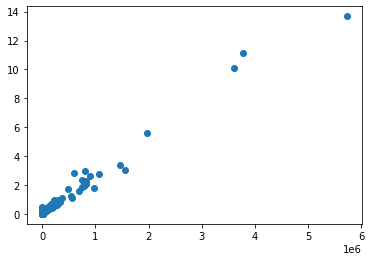

In [181]:
plt.scatter(y[:len(t)],np.sqrt(t))

Ahah, the time is quadratic in the input length... makes sense as I have many loops?

In [182]:
l = [sum(len(dd) for dd in d) for d in results]

TypeError: object of type 'int' has no len()

In [98]:
x[3]

['+ ', '+ ', '+ ']

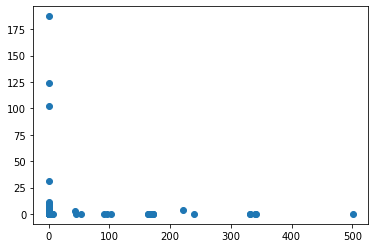

In [160]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.scatter([sum([len(yy) for yy in y]) for y in x],t)

In [81]:
%%time
diff1_changelist = [condenseDiffPoints(d, keep_comments=False, strip_test=True, strip_output=False) for d in diff1_instance]
diff1_changelist_ind = [i for i, d in enumerate(diff1_changelist) if d!=[]]
diff1_changelist_ind_added = [sum(1 for e in diff1_changelist[i] if e[0]=='+') - sum(1 for e in diff1_changelist[i] if e[0]=='-') for i in diff1_changelist_ind]
buffind_changed1 = np.array(diff1_changelist_ind)
buffind_added1 = buffind_changed1[np.nonzero(diff1_changelist_ind_added)[0]]
print(f'There are {len(diff1_changelist_ind)} FSA geometries with non-condensable alterations.')
print(f"There are {len(buffind_added1)} FSA geometries with altered total number of points.\n")
for i, j in zip(diff1_changelist_ind, diff1_changelist_ind_added):
    print(f"Altered FSA points at index {i}, with total {len(diff1_instance[i])} diff lines, net change {j} coordinates:")
    display(diff1_changelist[i])

KeyboardInterrupt: 

In [ ]:
s = 'asdf,saf'
print(s)
s = s.replace(',','\n')
print(s)
s = s.replace('\n',',')
print(s)

In [23]:
import diff_match_patch
help(diff_match_patch.diff_match_patch.diff_cleanupSemantic)

Help on function diff_cleanupSemantic in module diff_match_patch.diff_match_patch:

diff_cleanupSemantic(self, diffs)
    Reduce the number of edits by eliminating semantically trivial
    equalities.
    
    Args:
      diffs: Array of diff tuples.



In [7]:
import diff_match_patch
help(diff_match_patch.diff_match_patch)

Help on class diff_match_patch in module diff_match_patch.diff_match_patch:

class diff_match_patch(builtins.object)
 |  Class containing the diff, match and patch methods.
 |  
 |  Also contains the behaviour settings.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Inits a diff_match_patch object with default settings.
 |      Redefine these in your program to override the defaults.
 |  
 |  diff_bisect(self, text1, text2, deadline)
 |      Find the 'middle snake' of a diff, split the problem in two
 |        and return the recursively constructed diff.
 |        See Myers 1986 paper: An O(ND) Difference Algorithm and Its Variations.
 |      
 |      Args:
 |        text1: Old string to be diffed.
 |        text2: New string to be diffed.
 |        deadline: Time at which to bail if not yet complete.
 |      
 |      Returns:
 |        Array of diff tuples.
 |  
 |  diff_bisectSplit(self, text1, text2, x, y, deadline)
 |      Given the location of the 'middle snake', s

In [ ]:
wkt = ''
wkt.replace(',','\n')

In [ ]:
print(all([r!=None for r in results]))

In [ ]:
 |  BLANKLINEEND = re.compile('\\n\\r?\\n$')
 |  
 |  BLANKLINESTART = re.compile('^\\r?\\n\\r?\\n')

In [265]:
help(diff_match_patch.diff_match_patch.diff_linesToChars)

Help on function diff_linesToChars in module diff_match_patch.diff_match_patch:

diff_linesToChars(self, text1, text2)
    Split two texts into an array of strings.  Reduce the texts to a string
    of hashes where each Unicode character represents one line.
    
    Args:
      text1: First string.
      text2: Second string.
    
    Returns:
      Three element tuple, containing the encoded text1, the encoded text2 and
      the array of unique strings.  The zeroth element of the array of unique
      strings is intentionally blank.



In [ ]:
import diff_match_patch
#help(diff_match_patch.diff_match_patch.diff_linesToChars)
help(diff_match_patch.diff_match_patch)

In [266]:
import inspect
print(inspect.getsource(diff_match_patch.diff_match_patch.diff_linesToChars))

    def diff_linesToChars(self, text1, text2):
        """Split two texts into an array of strings.  Reduce the texts to a string
    of hashes where each Unicode character represents one line.

    Args:
      text1: First string.
      text2: Second string.

    Returns:
      Three element tuple, containing the encoded text1, the encoded text2 and
      the array of unique strings.  The zeroth element of the array of unique
      strings is intentionally blank.
    """
        lineArray = []  # e.g. lineArray[4] == "Hello\n"
        lineHash = {}  # e.g. lineHash["Hello\n"] == 4

        # "\x00" is a valid character, but various debuggers don't like it.
        # So we'll insert a junk entry to avoid generating a null character.
        lineArray.append("")

        def diff_linesToCharsMunge(text):
            """Split a text into an array of strings.  Reduce the texts to a string
      of hashes where each Unicode character represents one line.
      Modifies linearray and lineha

In [272]:
import inspect
print(inspect.getsource(diff_match_patch.diff_match_patch.diff_bisect))

    def diff_bisect(self, text1, text2, deadline):
        """Find the 'middle snake' of a diff, split the problem in two
      and return the recursively constructed diff.
      See Myers 1986 paper: An O(ND) Difference Algorithm and Its Variations.

    Args:
      text1: Old string to be diffed.
      text2: New string to be diffed.
      deadline: Time at which to bail if not yet complete.

    Returns:
      Array of diff tuples.
    """

        # Cache the text lengths to prevent multiple calls.
        text1_length = len(text1)
        text2_length = len(text2)
        max_d = (text1_length + text2_length + 1) // 2
        v_offset = max_d
        v_length = 2 * max_d
        v1 = [-1] * v_length
        v1[v_offset + 1] = 0
        v2 = v1[:]
        delta = text1_length - text2_length
        # If the total number of characters is odd, then the front path will
        # collide with the reverse path.
        front = delta % 2 != 0
        # Offsets for start and end of k loop

In [ ]:
help(ipypb.progressbar.ConfigurableProgressBar.__next__)

In [ ]:
indb_empty = [r==None for r in results]

In [ ]:
[len(r[0]) for r in results].index(8)

In [ ]:
results[809]

In [ ]:
import multiprocess
import testmp # Within notebooks, the function executed in a new process must be in a separate file, or else it will execute only within the notebook process
import time
import ipypb # Lightweight progress bar, source copied from GitHub

completed = 0
start_time = time.time()
if __name__ == '__main__':
    completed = 0
    N = gdf1.shape[0]
    results = [None]*N
    NUM_PROCESSES = 10
    with multiprocess.Pool(NUM_PROCESSES) as pool:
        print(f'Generating pool, P={NUM_PROCESSES}, N={N}')
        ret = [pool.apply_async(testmp.dmpDiff,(gdf1['Geometry'].iloc[ind], gdf1b['Geometry'].iloc[ind], ind)) for ind in range(N)]
        print('Processing pool')
        while True:
            indb_finished = [r.ready() for r in ret]
            indb_empty = [r==None for r in results]
            indb_update = [f and e for f, e in zip(indb_finished, indb_empty)]
            for i, b in enumerate(indb_update):
                if not b: continue
                results[i] = ret[i].get(999999)
                completed += 1
                #print(f'completed {completed: >4}/{N}, index {i: >4} in {time.strftime("%H:%M:%S", time.gmtime(sum(results[i][2])))}; total processor time {time.strftime("%H:%M:%S", time.gmtime(sum([sum(r[2]) for r in results if r!=None])))}, total wall time {time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))}')
            if all(indb_finished):
                break
        #print(f'Processing complete in {time.strftime("%H:%M:%S", time.gmtime(time.time()-start_time))}')
    wall_time = time.time()-start_time
    processor_time = sum([sum(r[2]) for r in results])
    print(f'Pool processing concluded, wall time {time.strftime("%H:%M:%S", time.gmtime(wall_time))}, processor time {time.strftime("%H:%M:%S", time.gmtime(processor_time))}, speedup {processor_time/wall_time:.3}x')

In [ ]:
indb_nochange = [len(r[0])==1 for r in results]
ind_change = [i for i, b in enumerate(indb_nochange) if (not b)]
print(ind_change)

In [ ]:
len(results[3][0])

In [ ]:
multiprocess.cpu_count()

In [ ]:
help(dmp_module)